# Model Fitting and simulation

As part of a project to make an arduino board PID system that controls an inverted pendulum to keep it from falling, by moving its center of rotation with a paper printer's moving part "the car", we decided to simulate the behauvior of the system with the PID control to optimize gain coeficients for capacity of control and diagnose limitations of the control system.

In order to get usefull information from the simulation, we collected data from the real pendulum to fit a model defined by diferential equations derived from lagrangian mechanics, the model parameters are fitted using the curve_fit function from the scipy module, to fit the solution to the diferential equation of the system, in the given initial conditions, to the real life data.

With the obtained parameters from the data of the free pendulum, and with prior knowledge of the car and board's behauvior we simulated the pendulum with the control system from a position disturbed from the equilibrium with different gain values and initial conditions



## Modeling a free pendulum and Fitting the model parameters to data gathered from the real system

Fitting a model of a dampened pendulum described by the differential equation derived below to real life data from a pendulum free fall from 60 degrees, with the angle mesured by our 3d printed encoder

#### Imports

In [2]:
import numpy as np
from math import tau
import matplotlib.pyplot as plt
from pytexit import py2tex
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.integrate import odeint

#### Retrieve and process the raw data

In [3]:
with open("./datos_filtrados.txt", 'r') as archivo:
    lineas = archivo.readlines()

t_values = []
a_values = []
v_values = []
d_values = []
for linea in lineas:
    data_values = linea.strip().split(';')
    if len(data_values) == 4:
        t_values.append(int(data_values[0][1:]))
        
        a_value = int(data_values[1][1:]) if data_values[1][0] == 'A' else int(data_values[1][1:])
        a_values.append(a_value)

        v_value = int(data_values[2][1:].split(' ')[0]) if data_values[2][0].isdigit() else int(data_values[2][1:])
        v_values.append(v_value)

        d_values.append(int(data_values[3][1:]))

y = np.array(a_values[117:])
y0 = y[0]
t = np.array(t_values[117:])
t = (t-t[0])/100000
print(len(t))
old_t = t
t = np.delete(t[1:],np.diff(t) <= 0)
y = np.delete(y[1:],np.diff(old_t) <= 0)
data = (t,y)

586


#### Graph the data

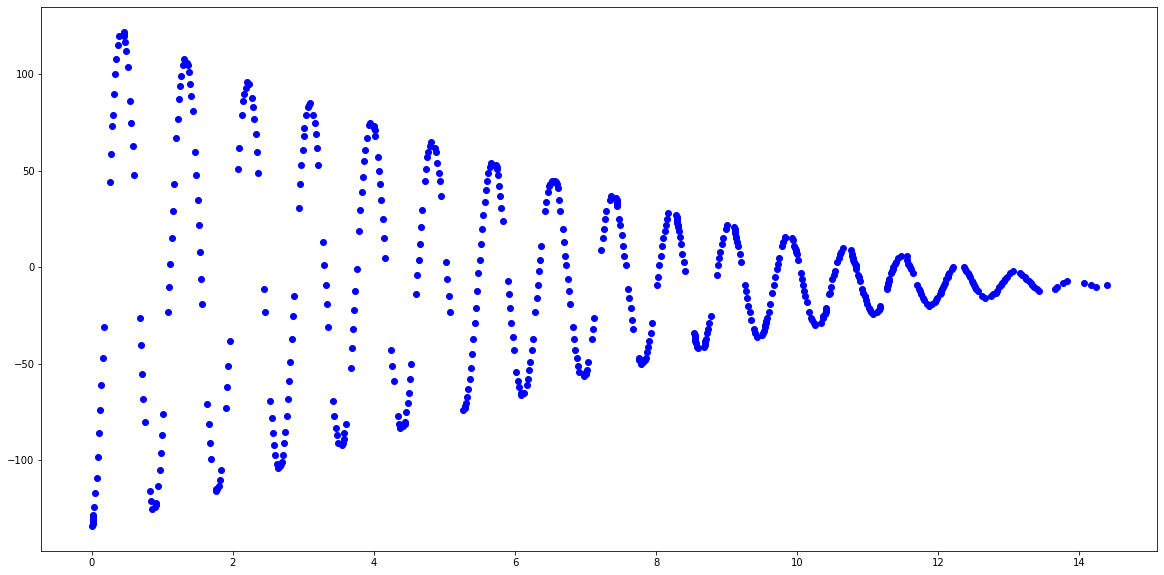

In [4]:
fig,ax = plt.subplots(figsize = (20,10))
ax.plot(t,y,'bo')

#### Equation of motion
\begin{align}
\frac{d^2 \theta}{{dt}^2} = m l a cos\left(\theta\right)-m l g sin\left(\theta\right)-\mu \left(\frac{d \theta}{dt}\right)+\tau_f \operatorname{sign}\left(\frac{d \theta}{dt}\right)
\end{align}
\begin{align}
\frac{d^2\theta}{dt^2} &= \frac{\kappa}{g} a\cos(\theta) - \kappa \sin(\theta) - \mu \theta' - \gamma \text{sign}(\theta')
\end{align}


theta: angle of the pendulum

g: Acceleration due to gravity

m: Mass of the pendulum

l: position of the center of mass ~ length of the pendulum

I: Moment of inertia of the pendulum

mu': Viscous friction coefficient

tau_f: Dinamic dry friction torque

a: Car acceleration

kappa, gamma, mu: constants, parameters of the model to fit

#### Deriving equations of motion with lagrangian mehtod

L: lagrangian

K: kinetic energy

U: potential energy

x: car position

lambda: variable length position in the pendulum for integration

pos: position of a diferencial element of the pendulum

rho: Line density of the pendulum



\begin{align}
L &= K - U \\
K &= \int k(\lambda) \, d\lambda \\
dk &= k(\lambda) \, d\lambda \\
k(\lambda) &= \frac{1}{2} \rho(\lambda) \left(\frac{d\text{pos}}{dt}\right)^2 \\
c &= \cos(\theta) \\
s &= \sin(\theta) \\
\text{pos}(\lambda) &= \left((x + \lambda s)i - \lambda c j\right) \\
v &= \frac{dx}{dt} \\
 \theta' &= \frac{d\theta}{dt} \\
\frac{d\text{pos}}{dt} &= \left((v + \lambda c \theta')i + \lambda s \theta' j\right) \\
k(\lambda) &= \frac{1}{2} \rho(\lambda) \left((v + \lambda c \theta')^2 + (\lambda s \theta')^2\right) \\
K &= \int \frac{1}{2} \rho(\lambda) \left((v + \lambda c \theta')^2 + (\lambda s \theta')^2\right) \, d\lambda \\
c^2 + s^2 &= 1 \\
K &= \int \frac{1}{2} \rho(\lambda) v^2 \, d\lambda + \int \frac{1}{2} \rho(\lambda) \lambda^2 \theta'^2 \, d\lambda + \int \rho(\lambda) v \lambda c \theta' \, d\lambda \\
I &= \int \rho(\lambda) \lambda^2 \, d\lambda \\
m &= \int \rho(\lambda) \, d\lambda \\
l &= \frac{1}{m} \int \rho(\lambda) \lambda \, d\lambda \\
K &= \frac{1}{2} m v^2 + \frac{1}{2} I \theta'^2 + v c \theta' m l \\
U &= -\int \rho(\lambda) g h \, d\lambda \\
U &= -\int \rho(\lambda) g \lambda c \, d\lambda \\
U &= -mglc \\
\text{Euler-Lagrange} \\
\frac{dL}{d\theta} &= \frac{d}{dt} \left(\frac{dL}{d\theta'}\right) \\
\frac{dL}{d\theta} &= -v s \theta' m l - mgl s \\
\frac{dL}{d\theta'} &= I \theta' + v c m l \\
a &= \frac{dv}{dt} \\
\frac{d}{dt} \left(\frac{dL}{d\theta'}\right) &= I \frac{d^2\theta}{dt^2} + a c m l - v s \theta' m l \\
\text{By Euler-Lagrange} \\
-v s \theta' m l - mgl s &= I \frac{d^2\theta}{dt^2} + a c m l - v s \theta' m l \\
-mgl s &= I \frac{d^2\theta}{dt^2} + a c m l \\
I \frac{d^2\theta}{dt^2} &= a c m l - mgl s \\
I \frac{d^2\theta}{dt^2} &= mla\cos(\theta) - mlg\sin(\theta) \\
\text{QED} \\
\text{Adding kinetic dry and viscous friction} \\
I \frac{d^2\theta}{dt^2} &= mla\cos(\theta) - mlg\sin(\theta) - \mu' \theta' + \tau_f \text{sign}(\theta')\\
\text{Dividing by I and renaming} \\
\frac{d^2\theta}{dt^2} &= \frac{\kappa}{g} a\cos(\theta) - \kappa \sin(\theta) - \mu \theta' - \gamma \text{sign}(\theta')
\end{align}


#### Fit the numerical solution of the model to the real data with scipy's curve_fit function to get the optimal model parameters

In [6]:
theta_0,theta_dot_0 = (y0,0)
S_0 = [theta_0,theta_dot_0]

def general_dSdt(S,t,kappa,mu,gamma):
    theta,theta_dot = S
    Dtheta = theta_dot
    Dtheta_dot = -kappa*np.sin(theta*tau/730) - mu*theta_dot*tau/730 - gamma*np.sign(theta_dot*tau/730) #theta - epsilon*np.sign(theta_0)*t
    Dtheta_dot = Dtheta_dot*730/tau
    return [Dtheta,Dtheta_dot]

def angle(t,kappa,mu,gamma):
    dSdt = lambda S,t: general_dSdt(S,t,kappa,mu,gamma)
    sol = odeint(dSdt,S_0,data[0])
    return sol.T[0]

params = curve_fit(angle,t,y,(55,0.22,0.3),maxfev = 10000)[0]
print(params)
fitted = lambda t: angle(t,*params)

[56.61732979  0.21999247  0.30022559]


In [7]:
kappa,mu,gamma = params

#### Graphing the solution of the optimized model against the real data

Check the Alternative_models notebook to see that this model outperforms the optimized analitic solutions to diferent simplyfied models

Text(0.5, 0, 'time(s)')

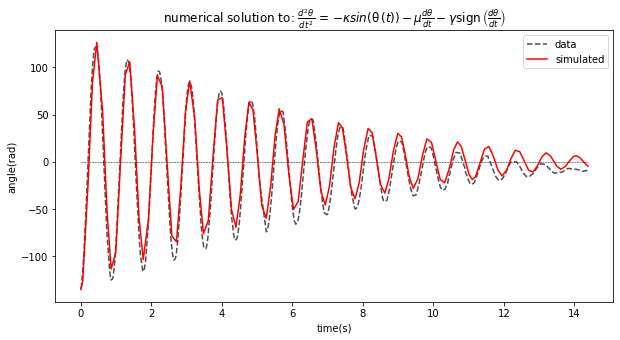

In [8]:
theta_0,theta_dot_0 = (y0,0)
S_0 = [theta_0,theta_dot_0]

def dSdt(t,S):
    theta,theta_dot = S
    Dtheta = theta_dot
    Dtheta_dot = -kappa*np.sin(theta*tau/730) - mu*theta_dot*tau/730
    Dtheta_dot = np.where(np.abs(Dtheta_dot) < np.abs(gamma),0,Dtheta_dot - gamma*np.sign(theta_dot))
    Dtheta_dot /= tau/730
    return [Dtheta,Dtheta_dot]

T = np.linspace(0,t[-1],500)

sol = solve_ivp(dSdt,(0,t[-1]),S_0)
left = py2tex('d**2*theta/dt**2',print_latex = False,print_formula = False) 
right = py2tex('- kappa*np.sin(theta(t)) - mu*(d*theta/dt) - gamma*np.sign(d*theta/dt)',print_latex = False,print_formula = False)

fig,ax = plt.subplots(figsize = (10,5))
ax.plot(t,y,'k--',alpha = .7,label = 'data')
ax.plot(t,t*0,'k--',linewidth = 0.5)
ax.plot(sol.t,sol.y[0],'r',label = 'simulated')

ax.set_title('numerical solution to: '+ left[1:-1] +' = ' + right [1:-1])
ax.legend()
ax.set_ylabel('angle(rad)')
ax.set_xlabel('time(s)')


## Using the optimized model to simulate the inverted pendulum controled by a PID system
The pendulum stands on top of a paper printer moving part "the car" which is moved by a stepper motor which we can control with an arduino board, the board can control the time between steps according to the information relayed from the sensor.

The goal of the control system is to keep the pendulum inverted and stop it from falling.

We use this simulation to try diferent gain coeficients to optimize capacity to control and diagnose limitations of the control system.

#### Defining the systems parameters

In [242]:
dt = 0.1*1/1000 #(s) 0.1ms, simulation dt used for simple eulers method integration

N = int(10/dt)

T = np.linspace(0,N*dt,N + 1)

#multiply all by dt 
dt_system = 5 #(s) 0.5ms, time that the arduino needs to process the information it has to return the orders to the stepper motor
car_reaction_time = 5*10 #(s) 5ms, minimal time the stepper motor needs between steps 
sensor_reaction_time = 3*10  #(s) 3ms, time interval between sensor retrieving information
derivative_calculation_time = 11*10 #(s) 10ms time interval between derivative calculation

full_step_time = 10*dt #(s) 1ms time it takes for the motor to complete the step<car_reaction_time
step_size = 0.4*1/1000 #(m) 0.4mm, length of a step, see linear regression notebook

Max_v = step_size/car_reaction_time #(m/s)
Max_int = 0.5 # cap for the integral
res = 1 #resolution of the sensor, 1 line of the encoder, given the structure of it its around half a degree
Max_x = .2 #(m) half the length of the printer on which the motor is placed, when the "car" reaches that length from either side it "fell"

Lambda = kappa/9.8 #m*len_mass_center= kappa/g from lagrangian deduction of the eqs of motion


last = -1

#### Defining functions used for the simulation

In [253]:
def cap(val,Max):#capping a value to a maximum to the positives and negatives
    return min(abs(val),Max)*np.sign(val)

def array_cap(val,Max):#=cap, used for ndarrays
    return np.where(abs(val)<Max,val,Max)[0]*np.sign(val)

def resolution(val,Min):#return the value unless its under the resolution of the sensor in which case returns zero
    return np.where(np.abs(val)>Min,val,0)

def Dtheta_dot_func(theta,theta_dot, a):#calculate the angle acceleration accordidng to the model, taking the cars motion into account
    Dtheta_dot = -Lambda*a*np.cos(theta*tau/730)-kappa*np.sin(theta*tau/730) - mu*theta_dot*tau/730
    Dtheta_dot = np.where((np.abs(Dtheta_dot) < np.abs(gamma)) & (theta_dot == 0),0,Dtheta_dot - gamma*np.sign(theta_dot))
    Dtheta_dot /= tau/730
    return Dtheta_dot

def sensor_actualize(theta): #get the information of the angle save it as a variable used for control and add to the integral
    global theta_int
    global theta_mesured
    global theta_dot_mesured
    if not i%derivative_calculation_time:
        theta_dot_mesured = np.round(theta)-theta_mesured
    theta_mesured = np.round(theta)
    error = resolution(shift(theta_mesured,365),res)
    theta_int += error*sensor_reaction_time*dt
    theta_int = cap(theta_int,Max_int)

def shift(angle, shift, tau = 730): #cap the angles posible values to -365 to +365 so the PID finds the closest way to get to the needed angle
    return (angle - shift + tau / 2) % tau - tau / 2
    
def PID(theta_int,theta,theta_dot):#PID system for controling the angle, returns a "velocity" which is used to calculate the time the car needs to wait until the next move
    error = resolution(shift(theta,365),res)
    response_vel = (
        kp*error+
        kd*theta_dot +
        ki*theta_int
        )
    response_vel = cap(response_vel,step_size/(car_reaction_time*dt))
    return -response_vel
    
def car_actualize(new_waiting_time):#using the ordered waiting time obtained from the PID, decide if it has to move, if it does set a variable move to true
    global move
    global waiting_time
    global wanted_direc
    global direc
    
    if waiting_time <= 0:
        move = True
        direc = wanted_direc
        waiting_time = new_waiting_time
    else:
        waiting_time = min(waiting_time-dt_system*dt,new_waiting_time)

def step_func(t): #functional form of the cars position velocity and acceleration during the step,
# the functions are chosen due to their simple nature and fit the constrains of the step in time and position, 
# and may be acurate due to the rotating nature of the stepping motor although it might not be necesary to have them modeled exactly
    x = -np.sin(tau*t/full_step_time) + tau*t/full_step_time
    v = -tau/full_step_time*np.cos(tau*t/full_step_time) + tau/full_step_time
    a = (tau/full_step_time)**2*np.sin(tau*t/full_step_time)
    x *= step_size/tau
    v *= step_size/tau
    a *= step_size/tau
    return x,v,a
    
def car_physics():#actualize the values of the cars position change velocity and acceleration when it has to move, if the step has been completed set the move variable to false
    global step_time
    global move
    global direc
    
    delta_x,v,a = step_func(step_time)
    
    step_time += dt
    if step_time > full_step_time:
        move = False
        step_time = 0
    
    return direc*np.array((delta_x,v,a))
    
def physics():#actualize the physical parameters of both the car and the pendulum
    global theta
    global theta_dot
    global Dtheta_dot
    
    global x
    global v
    global a
    
    if move:
        delta_x,v,a = car_physics()
        x += delta_x
    else:
        x,v,a = x,0,0
    
    Dtheta_dot = Dtheta_dot_func(theta,theta_dot, a)
    theta += theta_dot*dt
    theta_dot += Dtheta_dot*dt
    
    
def control():#if the sensor can get new information, use that, and if not use the values stored from the last sensing,
# calculate the waiting time for the car that the used information requires according to the PID, and actualize the car acording to that waiting time
    global theta_int
    global theta_mesured
    global theta_dot_mesured
    global move
    global waiting_time
    global direc
    global wanted_direc
    
    if not i%sensor_reaction_time:
        sensor_actualize(theta)
    response_vel = PID(theta_int,theta_mesured,theta_dot_mesured)    
    wanted_direc = np.sign(response_vel)
    
    if response_vel != 0:
        new_waiting_time = abs(step_size/response_vel)
    else:
        new_waiting_time = 10000000
    
    car_actualize(new_waiting_time)
    
def append():#append relevant values to lists that id like to graph later
    global theta_int_list
    global theta_list
    global theta_dot_list
    global Dtheta_dot_list
    global theta_mesured_list
    global theta_dot_mesured_list
    
    global x_list
    global v_list
    global a_list
    
    theta_list.append(theta)
    theta_dot_list.append(theta_dot)
    theta_int_list.append(theta_int)
    Dtheta_dot_list.append(Dtheta_dot)
    theta_mesured_list.append(theta_mesured)
    theta_dot_mesured_list.append(theta_dot_mesured)
    
    v_list.append(v)
    x_list.append(x)
    a_list.append(a)
    
def npify(interval):#make the lists ndarrays and fix them in an optional interval, its default is from the start till the car falls
    global theta_int_list
    global theta_list
    global theta_dot_list
    global Dtheta_dot_list
    global theta_mesured_list
    global theta_dot_mesured_list
    
    global x_list
    global v_list
    global a_list
    
    time = np.array(T[1:][interval])
    
    theta_int = np.array(theta_int_list[interval])
    theta = np.array(theta_list[interval])
    theta_dot = np.array(theta_dot_list[interval])
    Dtheta_dot = np.array(Dtheta_dot_list[interval])
    theta_mesured = np.array(theta_mesured_list[interval])
    theta_dot_mesured = np.array(theta_dot_mesured_list[interval])
    
    v = np.array(v_list[interval])
    x = np.array(x_list[interval])
    a = np.array(a_list[interval])
    
    return time, theta_int, theta, theta_dot, Dtheta_dot, x, v, a, theta_mesured, theta_dot_mesured


#### Setting initial conditions and simulating

In [274]:
theta_int,theta,theta_dot, x,v = [0,359,0, 0,0]# set the initial conditions, 365 is the pendulum up
    
ki,kp,kd = [10,10,0]#gains for the PID, the derivative is not well implemented yet

#initiating used variables
waiting_time = 0
theta_mesured = theta
theta_dot_mesured = 0
prom = theta

move = False
step_time = 0

#initiating lists
theta_int_list = []
theta_list = []
theta_dot_list = []
Dtheta_dot_list = []
theta_mesured_list = []
theta_dot_mesured_list = []


x_list = []
v_list = []
a_list = []

#initiate the last variable,  if its not changed it will be the last value of the T array
last = -1
    
#simulation, with every dt it calculates the physics of the system and saves the variables, and with every dt_system it calculats the control
for i in range(N):
    physics()
    if not i%dt_system:
        control()
    append()
    if abs(x) > Max_x:
        print('car fell')
        last = i
        break

time = T[1:]

In [275]:
def graph(T,time, theta_int, theta, theta_dot, x, v, a, show_x_lims = True, show_theta_lims = True,show_int_lims = True): #graph relevant variables
    fig,axs = plt.subplots(figsize = (30,20),nrows = 5)

    axs[0].plot(time,theta,'b')
    axs[1].plot(time,x,'r')
    axs[3].plot(time,theta_int,'g')
    axs[2].plot(time,v,'y')
    axs[4].plot(time,a,'m')
    Z = time
    
    if show_theta_lims:
        axs[0].plot(Z,0*Z + 365,'k--')
        axs[0].plot(Z,0*Z + 365 + res,'k--')
        axs[0].plot(Z,0*Z + 365 - res,'k--')
    if show_x_lims:
        axs[1].plot(Z,0*Z + Max_x,'k--')
        axs[1].plot(Z,0*Z - Max_x,'k--')
    if show_int_lims:
        axs[3].plot(Z,0*Z + Max_int,'k--')
        axs[3].plot(Z,0*Z - Max_int,'k--')
        axs[3].plot(Z,0*Z,'k--')

    axs[2].plot(time,array_cap(ki*np.array(theta_int),Max_v),'g--',linewidth = 0.5)

    axs[0].set_ylabel('theta')
    axs[1].set_ylabel('car x')
    axs[2].set_ylabel('car v')
    axs[3].set_ylabel('integral')
    axs[4].set_ylabel('car_a')

#### Graphing the full simulation 

Text(0, 0.5, 'theta_dot_dot')

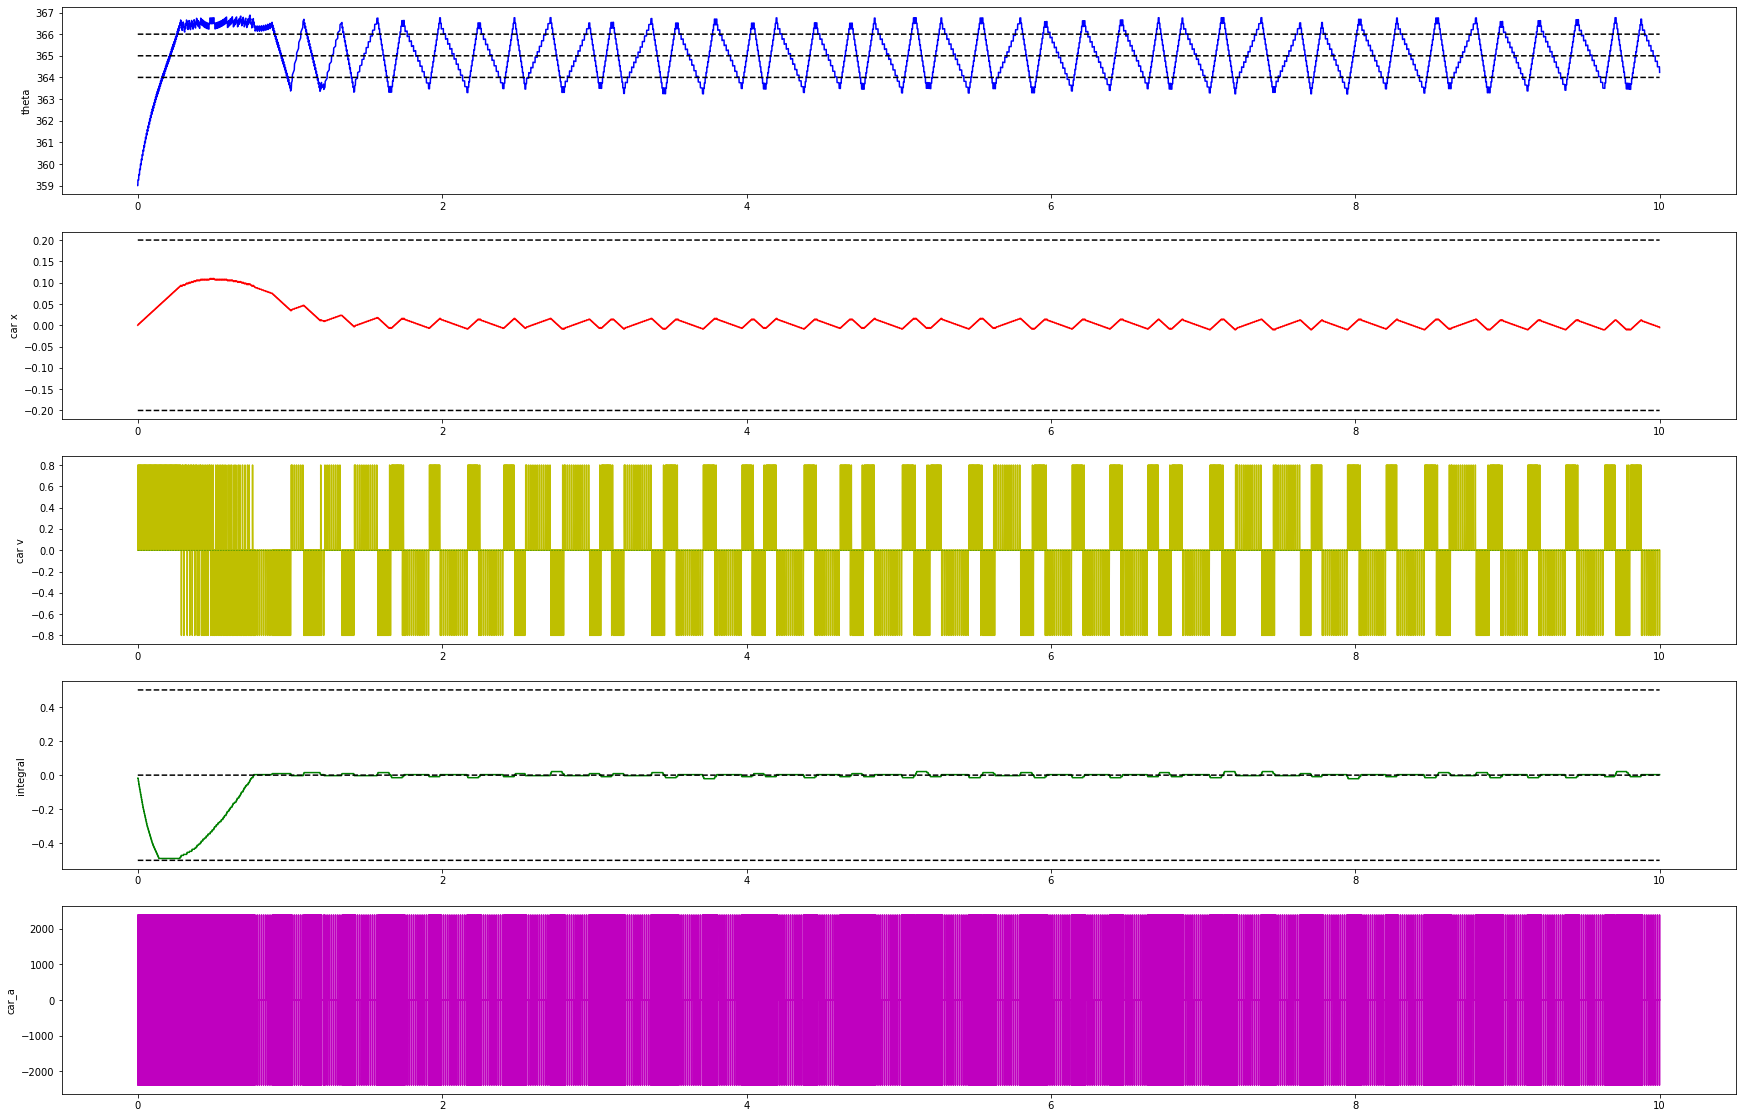

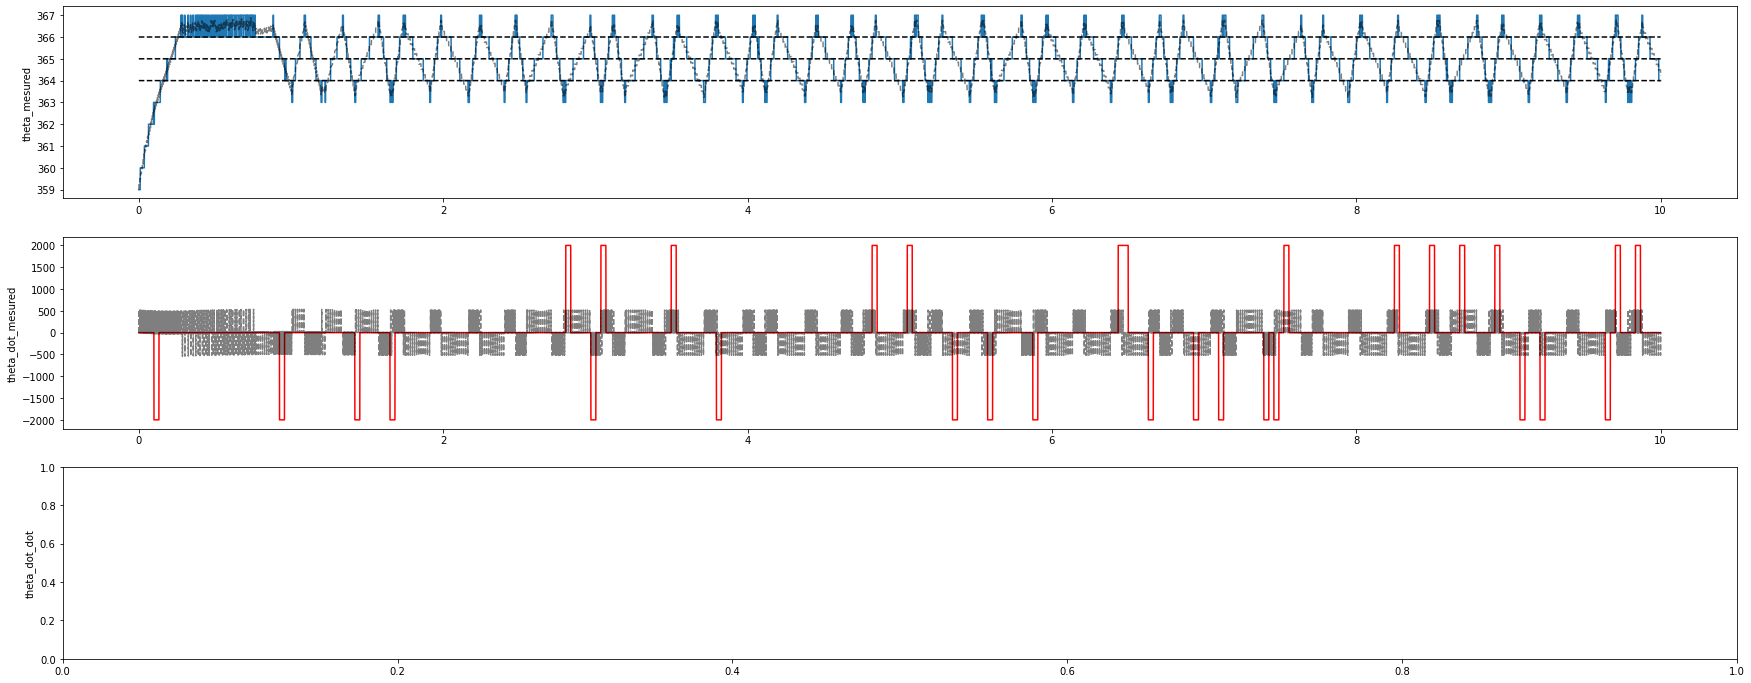

In [276]:
s = slice(0,last)
time, theta_int, theta, theta_dot, Dtheta_dot, x, v, a, theta_mesured, theta_dot_mesured = npify(s)
graph(T,time, theta_int, theta, theta_dot, x, v, a)
fig,axs = plt.subplots(figsize = (30,20*3/5),nrows = 3)
axs[0].plot(time,theta_mesured)
axs[1].plot(time,1/(dt_system*dt)*theta_dot_mesured,'r')

axs[0].plot(time,theta,'k--',alpha = 0.5)
axs[1].plot(time,theta_dot,'k--',alpha = 0.5)

axs[0].plot(time,0*time + 365,'k--')
axs[0].plot(time,0*time + 365 + res,'k--')
axs[0].plot(time,0*time + 365 - res,'k--')

axs[0].set_ylabel('theta_mesured')
axs[1].set_ylabel('theta_dot_mesured')
axs[2].set_ylabel('theta_dot_dot')

#### Graphing an interval from the simulation

Text(0, 0.5, 'theta_dot_mesured')

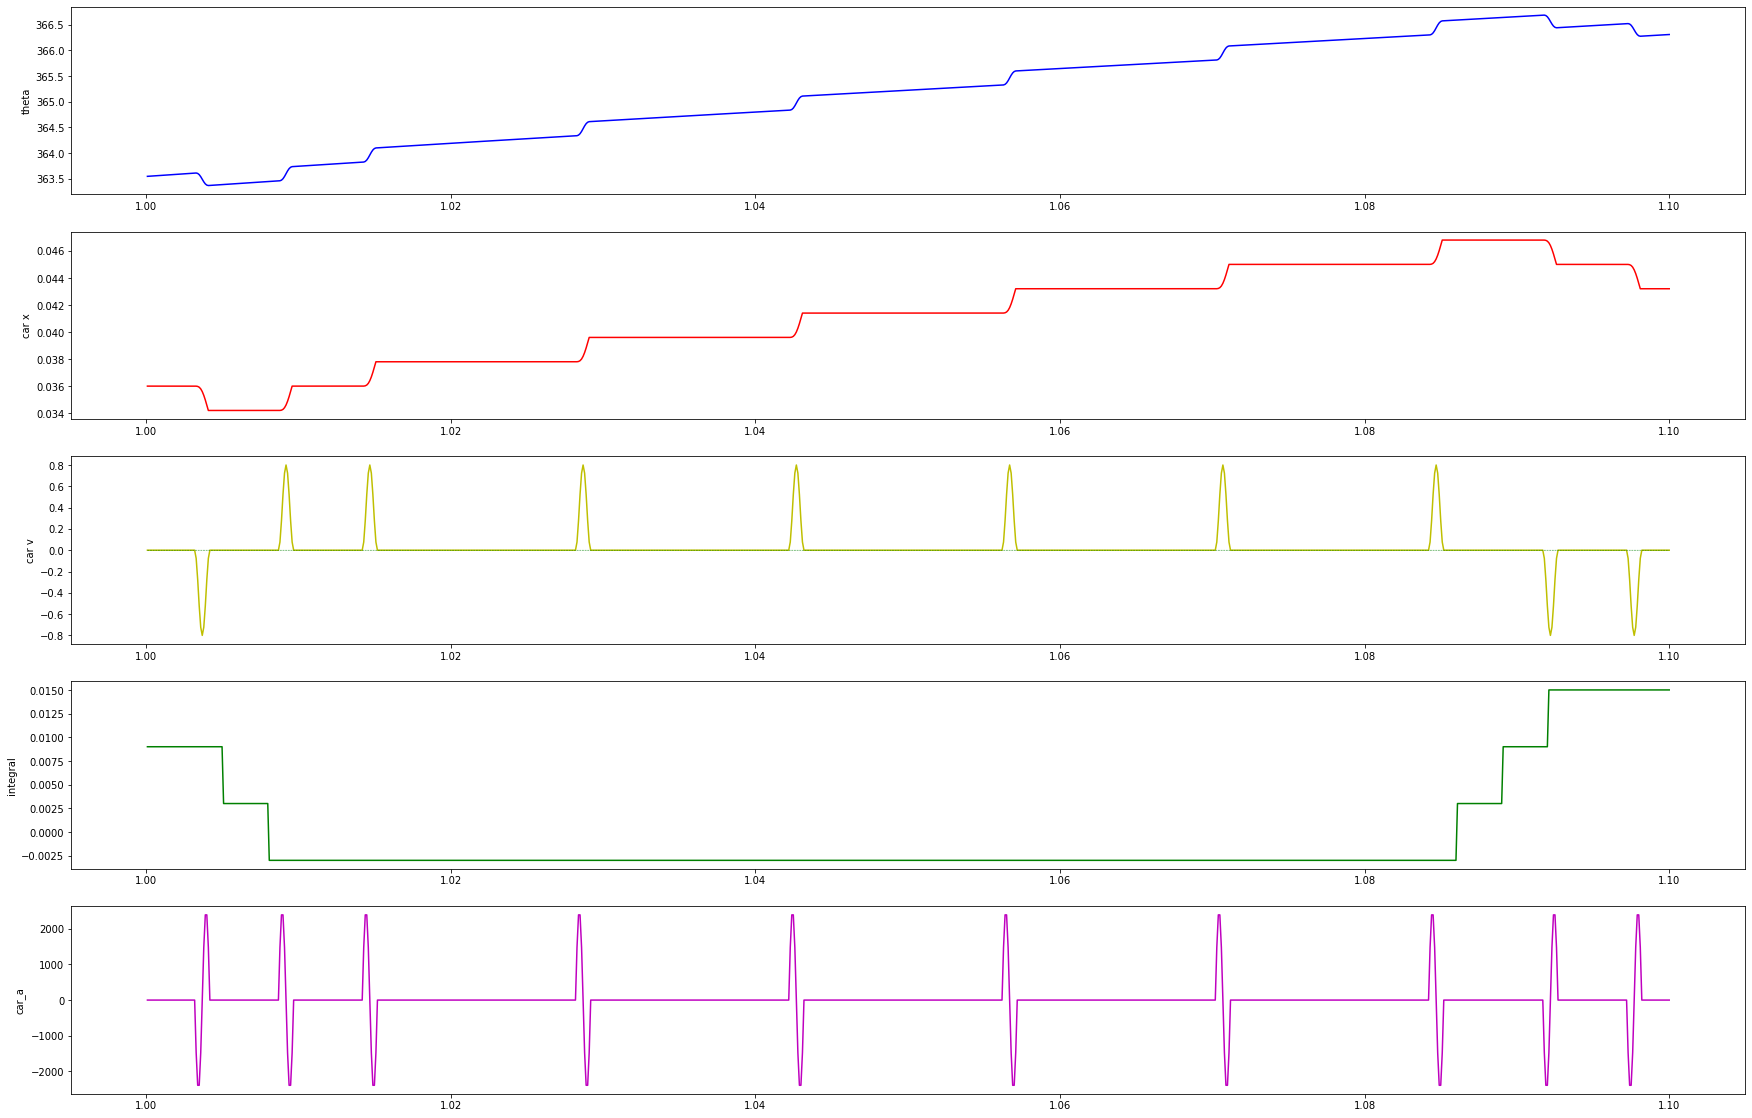

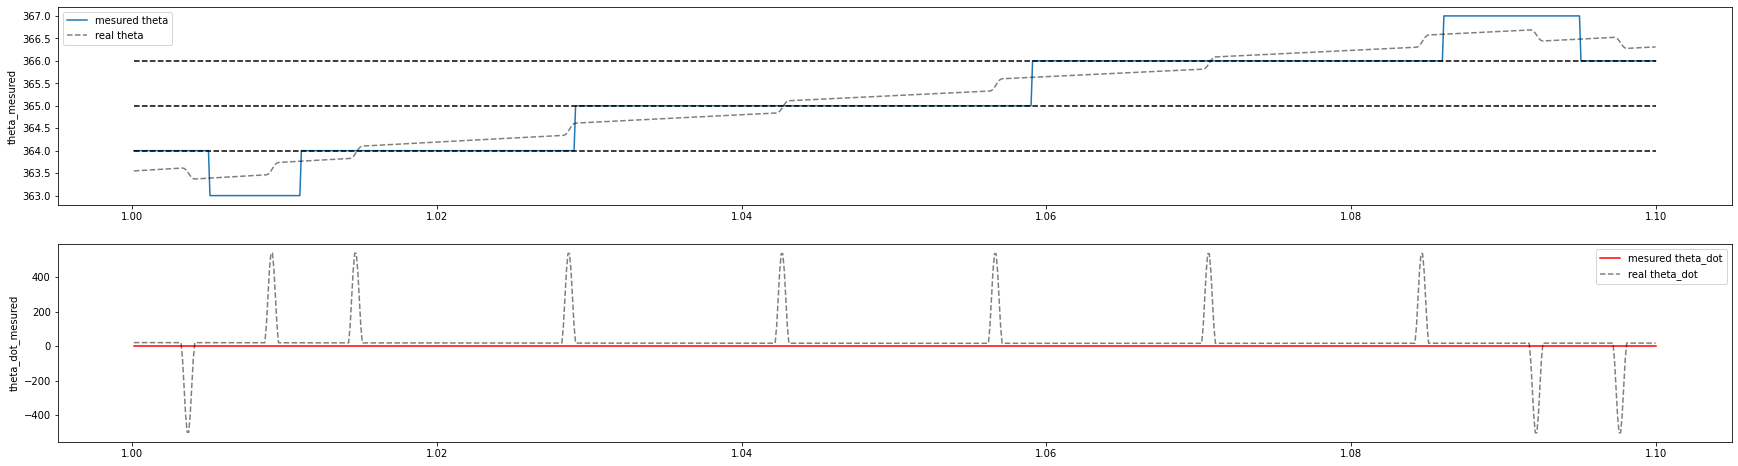

In [279]:
s = slice(10000,11000)
time, theta_int, theta, theta_dot, Dtheta_dot, x, v, a, theta_mesured, theta_dot_mesured = npify(s)
graph(T,time, theta_int, theta, theta_dot, x, v, a, show_theta_lims=False,show_x_lims=False,show_int_lims=False)
fig,axs = plt.subplots(figsize = (30,20*2/5),nrows = 2)

axs[0].plot(time,theta_mesured,label = 'mesured theta')
axs[1].plot(time,1/(dt_system*dt)*theta_dot_mesured,'r',label = 'mesured theta_dot')

axs[0].plot(time,0*time + 365,'k--')
axs[0].plot(time,0*time + 365 + res,'k--')
axs[0].plot(time,0*time + 365 - res,'k--')

axs[0].plot(time,theta,'k--',alpha = 0.5,label = 'real theta')
axs[1].plot(time,theta_dot,'k--',alpha = 0.5, label = 'real theta_dot')
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel('theta_mesured')
axs[1].set_ylabel('theta_dot_mesured')

## System parameters limiting the performance of the control system

From the shown interval of the simulation it can be seen that the step of the car seems to translate into a constant step closer to the desired angle, this change in the angle seems to be relatively independent from the shape of the step or the time it takes to complete it, this can be checked by the reader by modifing the full_step_time variable or changing the step_func function (satisfying the step conditions) and simulating.

So we realized that the ammount of angle change due to a step is a good messure of the capacity of the motor to keep the pendulum up, and can give us information of the limits of the system, i.e the maximal angle that can be equilibrated.

The following is a derivation of the formula for it:

$
\Delta x = x(T) - x(0) = \int_0^T v(t) \, dt\\
v(t) = \int a(t) \, dt\\
\Delta \theta = \theta(T) - \theta(0) = \int_0^T \theta'(t) \, dt\\
\theta'(t) = \int \frac{d^2\theta}{dt^2}(t) \, dt + \theta'_0\\
\frac{d^2\theta}{dt^2}(t) = \frac{\kappa}{g} \cdot a(t) \cdot \cos(\theta(t)) - \kappa \cdot \sin(\theta(t)) - \mu \cdot \theta'(t) - \gamma \cdot \text{sign}(\theta')\\
\text{ignoring friction because of the small time scale}\\
\frac{d^2\theta}{dt^2}(t) = \frac{\kappa}{g} \cdot a(t) \cdot \cos(\theta(t)) - \kappa \cdot \sin(\theta(t))\\
\cos(\theta + \Delta \theta) \approx \cos(\theta)\\
\sin(\theta + \Delta \theta) \approx \sin(\theta)\\
\frac{d^2\theta}{dt^2}(t) = \frac{\kappa'}{g} \cdot a(t) - \kappa"\\
\theta'(t) = \int \left(\frac{\kappa'}{g} \cdot a(t) - \kappa"\right) \, dt + \theta'_0 = \frac{\kappa'}{g} \cdot v(t) - \kappa" \cdot t + \theta'_0\\
\Delta \theta = \int \left(\frac{\kappa'}{g} \cdot v(t) - \kappa" \cdot t + \theta'_0\right) \, dt = \frac{\kappa'}{g} \cdot \Delta x - \frac{\kappa"}{2} \cdot T^2 + \theta'_0 \cdot T\\
\Delta \theta = \frac{\kappa}{g} \cdot \cos(\theta) \cdot \Delta x - \frac{\kappa}{2} \cdot \sin(\theta) \cdot T^2 + \theta'_0 \cdot T\\
$

T: time between steps

theta'_0: angular velocity before the step

Viewing the derivation for the angle change in a step we can see that it depends on the angle, which makes intuitive sense since when the pendulum is horizontal, no ammount of movement of the car could make it go up.

Also we can se that regardless of the shape of the step, after the step is completed and the minimal waiting time has passed the angle change is the same, it has a contribution from the cars motion, one from the current angular velocity and one from the acceleration gained from gravity.

The magnitud $\kappa/g\Delta x$ is the angle change in a step close to the top and it can be used to compute the angle change in any angle and the maximal angle that can be equilibrated

In our system that magnitud is:

In [15]:
kappa/9.8*step_size*730/tau

0.2684888721251355

The maximal deviation from equilibrium $D\theta$ can be solved setting the effect of the car to be compensated by falling by comparing the number of steps needed to get the pendulum to equilibrium and the number of time between steps $(T)$ that would make the fall due to angular velocity bigger than the increase in angle due to the step $\kappa/g\Delta x$

The increase in angle due to one step:
$\Delta\theta = \frac{\kappa}{g}\cos(\theta)\Delta x$

since $\cos(\pi) = -1$ and $\theta \approx \pi$

$\Delta\theta \approx -\frac{\kappa}{g}\Delta x$

The decrease in angle due to one $T$:

$\Delta\theta = -\theta'_0 T$

The change in angular velocity due to one $T$:

$\Delta\theta' = \frac{\kappa}{g} \cos(\theta) v(T) - \kappa \sin(\theta) T = - \kappa \sin(\theta) T$ 

since $\sin(\pi - x) \approx x$ and $\theta = \pi - d\theta$

where $d\theta = pi - \theta$ is the deviation from equilibrium at that moment

$\Delta\theta' \approx - \kappa d\theta T$ 

Starting from $\theta'_0 = 0$, and ignoring the falling due to angular velocity (this is not accuarate but it gives us an optimistic expected maximal deviation, we would calculate one that is more pessimistic and the real value woulld be between the two) the change in angle due to $N$ steps is:

$-N \cdot \frac{\kappa}{g} \Delta x$

The change in anglular velocity due to $N$ times between steps $(T)$ is:

$\sum \limits _{j = 0}^{N} -\kappa d\theta_j T$

$d\theta_j = -j \cdot \frac{\kappa}{g} \Delta x + d\theta_0$

$\sum \limits _{j = 0}^{N} -\kappa (- j \cdot \frac{\kappa}{g} \Delta x + d\theta_0 )T $

$\sum \limits _{j = 0}^{N} (\kappa \cdot j \cdot \frac{\kappa}{g} \Delta x \cdot T -\kappa d\theta_0 T)$

$\sum \limits _{j = 0}^{N} \kappa \cdot j \cdot \frac{\kappa}{g} \Delta x \cdot T - \sum \limits _{j = 0}^{N} \kappa d\theta_0 T$

$ \kappa \frac{\kappa}{g} \Delta x \cdot T \sum \limits _{j = 0}^{N}(j) - N\cdot\kappa d\theta_0 T$

from the formula for the sum of the first N integers

$ \kappa \frac{\kappa}{g} \Delta x \cdot T \frac{(N+1)N}{2} - N\cdot\kappa d\theta_0 T$

if the number of steps needed to get the pendulum to its equilibrium point causes the accumulated angular velocity to exceed the step size the pendulum will fall, therefore the maximum number of steps the car can take before it starts falling is the solution to the equation:

$ \kappa \frac{\kappa}{g} \Delta x \cdot T \frac{(N+1)N}{2} - N\cdot\kappa d\theta_0 T = \frac{\Delta x}{T}$

The value for the initial deviation in this case is the maximal posible deviation the system could restore to equilibrium $D\theta$ which is $N \cdot \Delta x$ given that in N steps the car reaches equilibrium with the maximal tolerated angular velocity

$ \kappa \frac{\kappa}{g} \Delta x \cdot T \frac{(N+1)N}{2} - N\cdot\kappa \cdot N \cdot \Delta x \cdot T = \frac{\Delta x}{T}$

dividing everything by $\Delta x $ and rearranging we get:

$(\frac{\kappa^2 T}{2 g}-\kappa T)N^2 + \frac{\kappa^2 T}{2 g} N - \frac{1}{T} = 0$

$a = (\frac{\kappa^2 T}{2 g}-\kappa T)$ , $b = \frac{\kappa^2 T}{2 g}$ $c = - \frac{1}{T}$

$aN^2 + bN +c = 0$

$r1 = \frac{-b + \sqrt{b^2 - 4 a c}}{2 a}$

$r2 = \frac{-b - \sqrt{b^2 - 4 a c}}{2 a}$

a is $\kappa T (\frac{\kappa}{2 g} - 1)$ and $\frac{\kappa}{2 g}$ is bigger than one (see below) a is positive therefore only root one can return a positive number of steps

In [16]:
kappa/(2*9.8)

2.8886392747908736

In [17]:
B = kappa**2 * (car_reaction_time*dt) / (2*9.8)
A = B - kappa*(car_reaction_time*dt)
C = -1/(car_reaction_time*dt)

steps = (-B + np.sqrt(B**2 - 4*A*C))/(2*A)

print(steps)

max_dev = steps*kappa/9.8*step_size*730/tau
print(max_dev)

18.591455360722605
4.991598880965217


from the calculated value we can see that the maximal deviation from equilibrium would be arround 5 encoder lines arround 2.5 degrees, the reader can change the initial value of theta to be 358 to see that the pendulum falls but with 359 it reaches equilibrium, since equilibrium is at 365 then the value of the maximal deviation from the simulation is 6 encoder lines, which makes sense because the car stops responding once the resolution doesnt allow us to respond to the actual deviation, and since the resolution is 1 the actual max_dev is N + 1

In [18]:
max_dev + 1

5.991598880965217

#### Conclusions

We found the main limitations of the system are the power of the stepper motor and the car falling off the printer, we didnt find the resolution of the sensor nor the delay in receving information to be significant problems, the problem of the printer can be somewhat mitigated by the integral gain and we will test when its implemented how the derivative gain affects the behaviour of the system

In [216]:
np.round(1.6)

2.0